# Fractal Growth in Circular Cellular Automata

This notebook implements and explores the circular cellular automaton (CCA) introduced by Sun, Wang, and Wu (Physical Review E, 2001). The model grows a two-dimensional lattice ring-by-ring under an intermediate crowding rule, producing fractal and chaotic spatial patterns.

We reproduce key results from the paper and systematically explore parameter sensitivity, fractal scaling, and model robustness.


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from math import log

plt.rcParams["figure.figsize"] = (6,6)

plt.rcParams.update({
    "font.size": 12,
    "figure.dpi": 150
})


## Model Definition

The lattice is initialized with a single occupied seed at the center. Growth proceeds outward in successive circular rings.

A site becomes occupied if and only if exactly one of its four nearest neighbors is already occupied (intermediate crowding rule).

The parameter δ controls the thickness and position of each growth ring, introducing sensitivity to initial conditions.


In [35]:
N = 401
center = N // 2


In [36]:
def ring_sites(radius, delta=0):
    sites = []
    rmin = radius - 1 + delta
    rmax = radius + delta
    
    for i in range(center-radius-2, center+radius+3):
        for j in range(center-radius-2, center+radius+3):
            r = np.sqrt((i-center)**2 + (j-center)**2)
            if rmin <= r <= rmax:
                if 0 < i < N-1 and 0 < j < N-1:
                    sites.append((i, j))
    return sites


In [37]:
def count_neighbors(grid, i, j):
    return (
        grid[i+1, j] +
        grid[i-1, j] +
        grid[i, j+1] +
        grid[i, j-1]
    )


## Ring-by-Ring Growth Algorithm

For each radius i, sites belonging to the corresponding circular shell are updated sequentially following a line-scanning order.

The growth rule is applied locally at each site, generating emergent global structure through repeated iterations.


In [38]:
def grow_ring(grid, radius, delta=0):
    sites = ring_sites(radius, delta)
    sites.sort()  # line scanning

    for i, j in sites:
        if grid[i, j] == 0:
            if count_neighbors(grid, i, j) == 1:
                grid[i, j] = 1
    return grid


In [39]:
def generate_growth(delta=0.0):
    grid = np.zeros((N, N), dtype=int)
    grid[center, center] = 1
    
    frames = []
    max_radius = center - 2
    
    for r in range(1, max_radius):
        grid = grow_ring(grid, r, delta)
        if r % 3 == 0:
            frames.append(grid.copy())
            
    return np.array(frames), grid


## Baseline Fractal Pattern (δ = 0)

We first reproduce the regular fractal geometry reported in the Physical Review E paper, corresponding to δ = 0.

This configuration produces a Sierpinski-type triangular fractal structure.


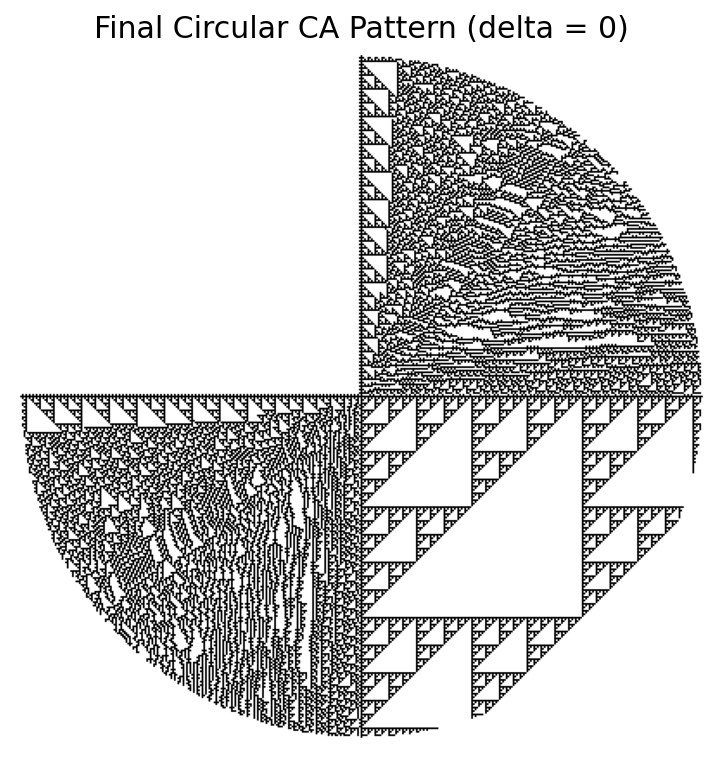

In [40]:
frames, final_grid = generate_growth(delta=0.0)

plt.figure(figsize=(6,6))
plt.imshow(final_grid, cmap="binary")
plt.title("Final Circular CA Pattern (delta = 0)")
plt.axis("off")
plt.show()


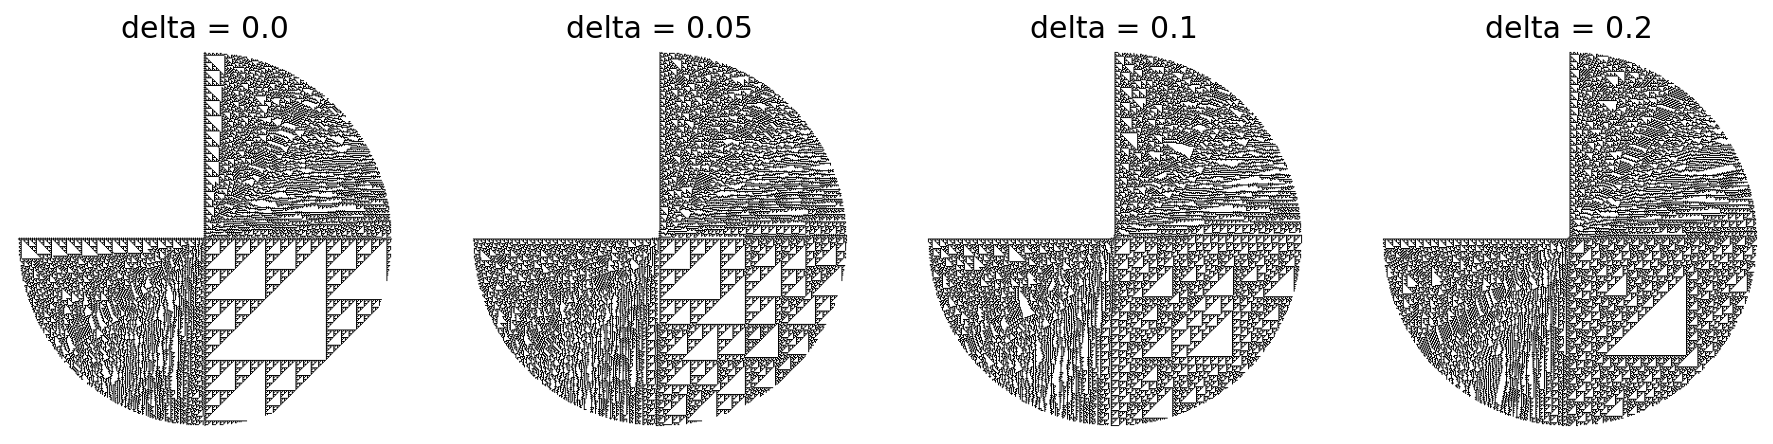

In [41]:
deltas = [0.0, 0.05, 0.1, 0.2]

fig, axes = plt.subplots(1, len(deltas), figsize=(15,4))

for ax, d in zip(axes, deltas):
    _, g = generate_growth(delta=d)
    ax.imshow(g, cmap="binary")
    ax.set_title(f"delta = {d}")
    ax.axis("off")

plt.show()


## Fractal Dimension via Box-Counting Method

To quantify the emergent geometry, we compute the fractal dimension using the box-counting method.

The number of occupied boxes N(ε) is measured for varying box sizes ε, and the fractal dimension D is obtained from the scaling relation:

log N(ε) ∝ D log(1/ε)


In [42]:
def box_count(Z, k):
    S = np.add.reduceat(
        np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                           np.arange(0, Z.shape[1], k), axis=1)
    return np.count_nonzero(S)


In [43]:
def fractal_dimension(Z):
    Z = (Z > 0).astype(int)
    sizes = 2**np.arange(1, int(np.log2(N))-1)
    counts = []

    for size in sizes:
        counts.append(box_count(Z, size))

    logsizes = np.log(1/sizes)
    logcounts = np.log(counts)

    # fit middle scaling region only
    fit_slice = slice(2, -2)
    coeffs = np.polyfit(logsizes[fit_slice], logcounts[fit_slice], 1)

    return coeffs[0]


## Phase Diagram: Fractal Dimension vs Growth Parameter δ

We systematically vary δ to explore how small changes in the growth condition affect the global morphology.

The resulting fractal dimension D(δ) characterizes the transition from regular fractal growth to chaotic structures.


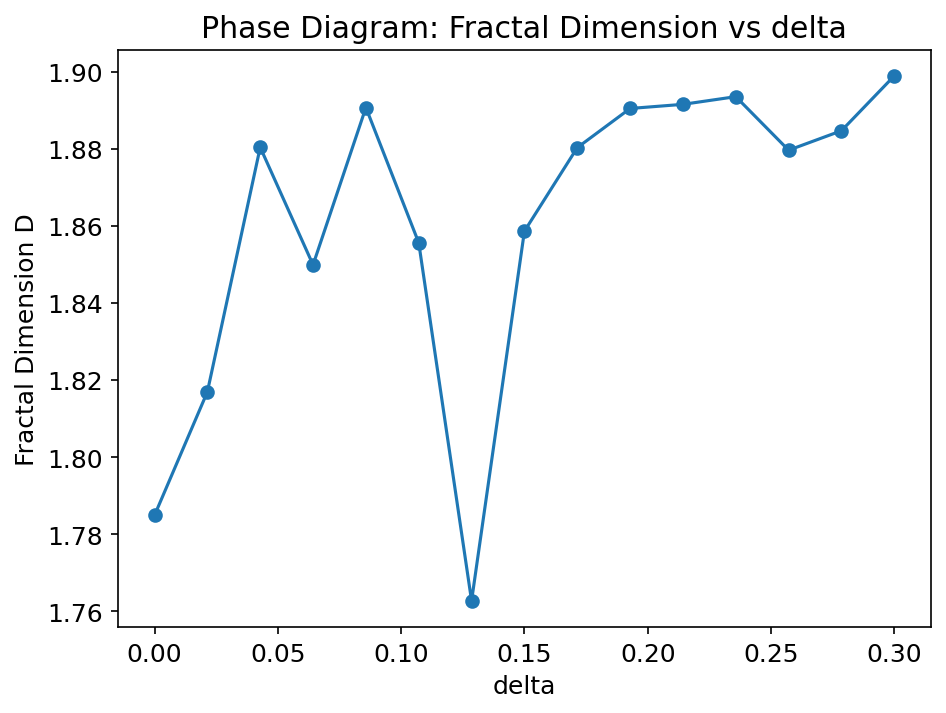

In [44]:
delta_values = np.linspace(0.0, 0.3, 15)
D_values = []

for d in delta_values:
    _, g = generate_growth(delta=d)
    D = fractal_dimension(g)
    D_values.append(D)

plt.figure(figsize=(7,5))
plt.plot(delta_values, D_values, 'o-')
plt.xlabel("delta")
plt.ylabel("Fractal Dimension D")
plt.title("Phase Diagram: Fractal Dimension vs delta")
#plt.grid(True)
plt.show()


## Ring-Resolved Occupation Statistics

Following the original paper, we compute the occupation fraction η(i) for each growth ring i:

η(i) = (number of occupied sites in ring i) / (total sites in ring i)

This reveals regular scaling for δ = 0 and chaotic fluctuations for δ > 0.


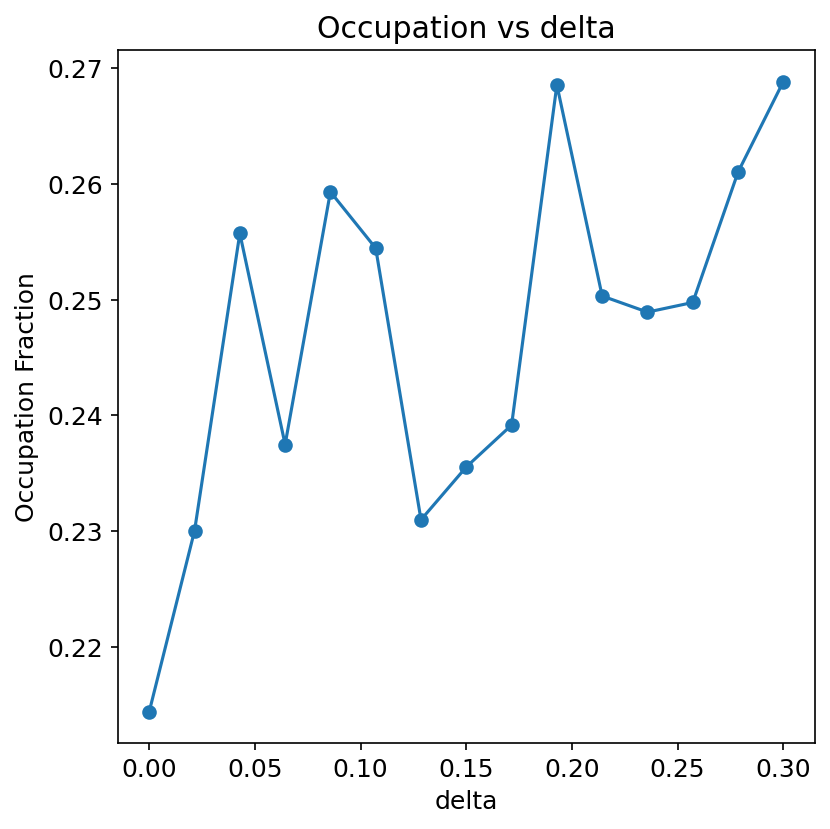

In [45]:
occ = []

for d in delta_values:
    _, g = generate_growth(delta=d)
    occ.append(np.mean(g))

plt.plot(delta_values, occ, 'o-')
plt.xlabel("delta")
plt.ylabel("Occupation Fraction")
plt.title("Occupation vs delta")
#plt.grid(True)
plt.show()


## Scaling of Occupation Fraction Across Growth Rings

To further characterize the growth dynamics, we analyze the occupation fraction η(i) for each growth ring i, defined as:

η(i) = (number of occupied sites in ring i) / (total number of sites in ring i)

This quantity measures how densely each successive circular shell is filled during growth.

For δ = 0, the occupation fraction exhibits regular fluctuations associated with self-similar fractal structure, with prominent peaks occurring at characteristic radii. 

For δ > 0, these regular features disappear and η(i) displays strong irregular fluctuations, indicating chaotic sensitivity to growth conditions.

This reproduces the qualitative behavior reported in Figure 4 of Sun et al. (Physical Review E, 2001).


In [46]:
def ring_occupation(grid, radius, delta=0):
    sites = ring_sites(radius, delta)
    if len(sites) == 0:
        return 0
    occ = sum(grid[i, j] for i, j in sites)
    return occ / len(sites)


In [47]:
def occupation_vs_radius(delta=0):
    grid = np.zeros((N, N), dtype=int)
    grid[center, center] = 1
    
    max_radius = center - 2
    eta = []
    radii = []

    for r in range(1, max_radius):
        grid = grow_ring(grid, r, delta)
        eta.append(ring_occupation(grid, r, delta))
        radii.append(r)

    return np.array(radii), np.array(eta)


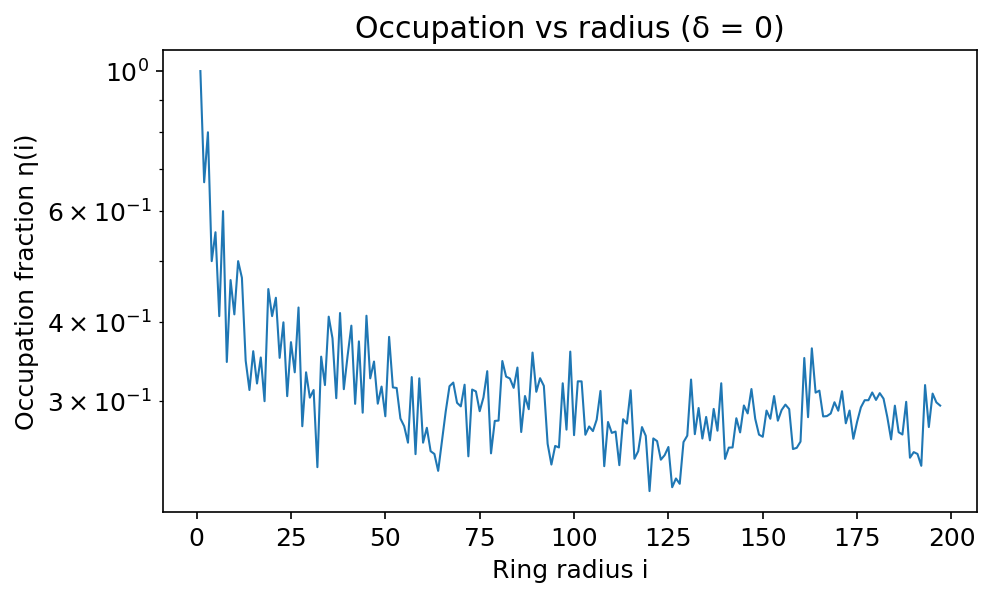

In [48]:
r0, eta0 = occupation_vs_radius(delta=0.0)

plt.figure(figsize=(7,4))
plt.plot(r0, eta0, lw=1)
plt.xlabel("Ring radius i")
plt.ylabel("Occupation fraction η(i)")
plt.title("Occupation vs radius (δ = 0)")
plt.yscale("log")   # paper uses log-like scale to show structure
#plt.grid(True)
plt.show()


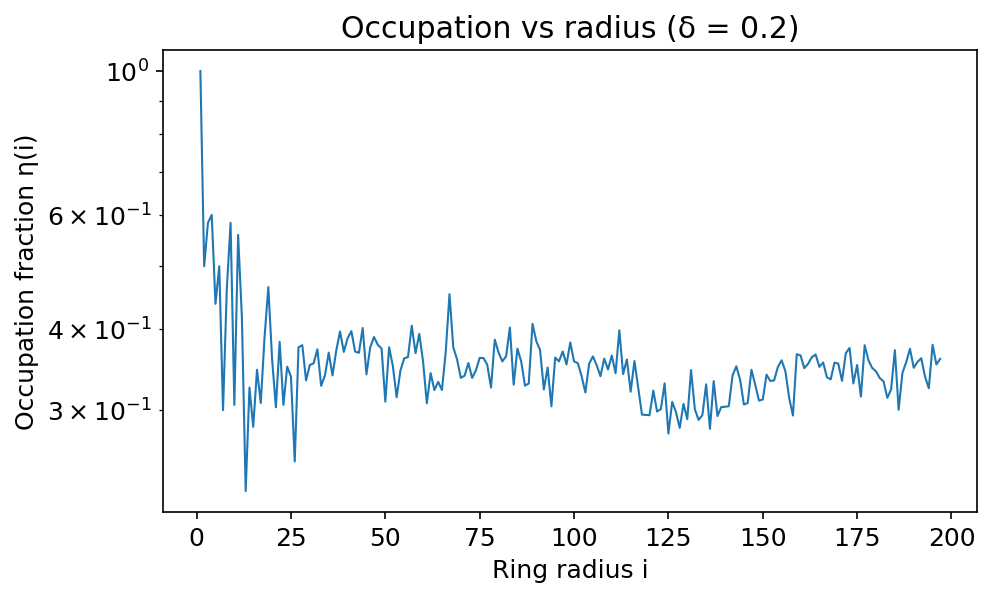

In [49]:
r1, eta1 = occupation_vs_radius(delta=0.2)

plt.figure(figsize=(7,4))
plt.plot(r1, eta1, lw=1)
plt.xlabel("Ring radius i")
plt.ylabel("Occupation fraction η(i)")
plt.title("Occupation vs radius (δ = 0.2)")
plt.yscale("log")
#plt.grid(True)
plt.show()


## Finite-Size Effects

To test the robustness of the fractal scaling, we repeat the simulation for different lattice sizes.

Convergence of the fractal dimension with increasing system size indicates scale-invariant behavior.


In [50]:
def run_for_size(Nsize, delta=0.0):
    global N, center
    N = Nsize
    center = N // 2
    
    _, grid = generate_growth(delta)
    D = fractal_dimension(grid)
    occ = np.mean(grid)
    
    return D, occ


In [57]:
sizes = [301, 401, 501]
delta_test = 0.0

Ds = []
occs = []

for s in sizes:
    D, occ = run_for_size(s, delta=delta_test)
    Ds.append(D)
    occs.append(occ)

for s, d, o in zip(sizes, Ds, occs):
    print(f"N = {s:3d} | Fractal Dimension D = {d:.4f} | Occupation = {o:.4f}")


N = 301 | Fractal Dimension D = 1.9107 | Occupation = 0.2112
N = 401 | Fractal Dimension D = 1.7849 | Occupation = 0.2144
N = 501 | Fractal Dimension D = 1.7965 | Occupation = 0.2075


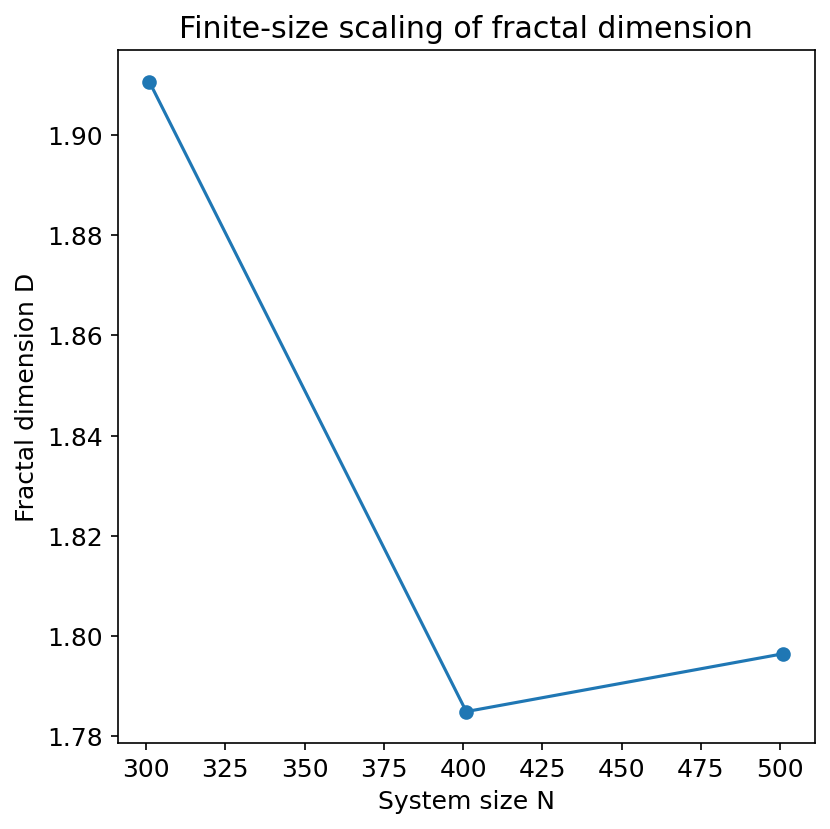

In [58]:
plt.plot(sizes, Ds, 'o-')
plt.xlabel("System size N")
plt.ylabel("Fractal dimension D")
plt.title("Finite-size scaling of fractal dimension")
#plt.grid(True)
plt.show()


## Sensitivity to Growth Sequence

The original model emphasizes dependence on the order in which sites are updated within each growth ring.

We compare line-scanning updates with clockwise updates to examine how microscopic update order affects macroscopic geometry.


In [53]:
def grow_ring_clockwise(grid, radius, delta=0):
    sites = ring_sites(radius, delta)
    
    # sort by angle around center (clockwise)
    sites.sort(key=lambda x: np.arctan2(x[0]-center, x[1]-center))
    
    for i, j in sites:
        if grid[i, j] == 0:
            if count_neighbors(grid, i, j) == 1:
                grid[i, j] = 1
    return grid


In [54]:
def generate_growth_sequence(delta=0.0, mode="scan"):
    grid = np.zeros((N, N), dtype=int)
    grid[center, center] = 1
    
    max_radius = center - 2
    
    for r in range(1, max_radius):
        if mode == "scan":
            grid = grow_ring(grid, r, delta)
        else:
            grid = grow_ring_clockwise(grid, r, delta)
            
    return grid


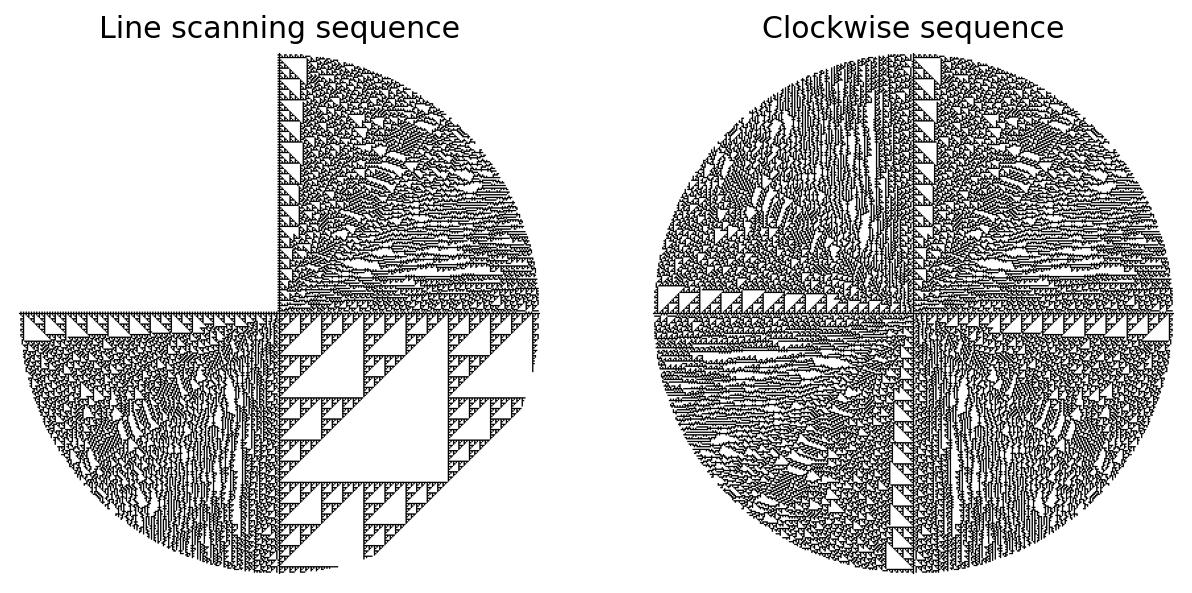

In [55]:
grid_scan = generate_growth_sequence(delta=0.0, mode="scan")
grid_clock = generate_growth_sequence(delta=0.0, mode="clock")

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(grid_scan, cmap="binary")
ax[0].set_title("Line scanning sequence")
ax[0].axis("off")

ax[1].imshow(grid_clock, cmap="binary")
ax[1].set_title("Clockwise sequence")
ax[1].axis("off")

plt.show()


## Discussion and Conclusions

The circular cellular automaton demonstrates how simple local growth rules can generate complex fractal and chaotic spatial structures.

Regular Sierpinski-type fractals emerge for δ = 0, while increasing δ introduces sensitivity to initial conditions and irregular morphologies.

Quantitative analysis through fractal dimension, occupation statistics, finite-size scaling, and update-sequence dependence confirms the self-organized and scale-invariant nature of the model, consistent with Physical Review E results.
